# Crossing the transcendental divide: from Schottky groups to algebraic curves

## Samantha Fairchild, Ángel David Ríos Ortiz

This is a Julia 1.8.2 notebook including computations used in the above named paper

All code was run on a MacBook Air with chip Apple M1 2020 and 8 GB memory


In [1]:
import Pkg   ##Import any necessary packages
Pkg.add("LinearAlgebra")
Pkg.add("ImplicitEquations")
Pkg.add("Plots")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [2]:
using LinearAlgebra ##We use these particular Packages
using ImplicitEquations
using Plots

## Generating elements of the free group as matrices

It is important to minimize matrix multiplication, so we generate words of bounded length, keeping a tag to keep track of the first and last letter of each word to allow for computing representatives of cosets.

In [3]:
##Function for constructing elements of free group up to bounded length
# list is elements of the form (matrix, last letter, first letter)

##INPUT: len is an integer >1
# g is the genus of the curve we are working with
# mat is a list of g 2x2 matrices generating the free group

function all_words_bounded_length(len,g, mat) #generate all words in the free group of length at most len
    word_list= [(Matrix{ComplexF64}(I,2,2),0,0)]  #initiate identity element in list
    for lev in 1:len 
        old_list = copy(word_list) #take all words of length < lev
        word_list = [(Matrix{ComplexF64}(I,2,2),0,0)]
        for oldword in old_list #iterate through all words of length = lev-1 and multiply to generate all words of length lev
            for j in 1:g
                if oldword[3] !=0 #if not multiplying by the identity, first letter is unchaged
                    if oldword[2] != -j 
                        push!(word_list, (Matrix{ComplexF64}(oldword[1]*mat[j]), j, oldword[3]))
                    end
                    if oldword[2] != j
                        push!(word_list, (Matrix{ComplexF64}(oldword[1]*mat[j]^(-1)), -j, oldword[3]))
                    end
                else #if multiplying by identity, first letter is last letter
                    if oldword[2] != -j 
                        push!(word_list, (Matrix{ComplexF64}(oldword[1]*mat[j]), j, j))
                    end
                    if oldword[2] != j
                        push!(word_list, (Matrix{ComplexF64}(oldword[1]*mat[j]^(-1)), -j, -j))
                    end
                end
            end
        end     
    end
    return word_list
end


all_words_bounded_length (generic function with 1 method)

## Helper Functions

In [4]:
##Function for easier evaluation of Mobius transformations
function mobius(matrix, num) #given a matrix [a b ; c d] and a number z, return az+b/cz+d
    mobius = ((matrix[1,1]* num) + matrix[1,2])/((matrix[2,1]*num) + matrix[2,2])
    return mobius
end

##Function for constructing centers and radii of the circles
function point_construct(eta, theta, g)
    z1 = exp(im*((theta+eta)/2)) *sec((theta-eta)/2) #Center of generating circle
    zs = [exp(((j-1)*2*pi*im) / g) * z1 for j in 1:g] #input first tuple of centers z1,....,zg
    ws = [exp(((j-1)*2*pi*im) / g)*conj(z1) for j in 1:g] #input second tuple of center w1,...., wg
    rs = [tan((theta-eta)/2) for _ in 1:g] #input radii of circles r1,...,rg
    return (zs, ws, rs)
end 

##Function for Constructing Matrices of the Schottky Group
function matrix_construct(ws, zs, rs)
    g = length(ws)
    M = zeros(Complex, 2,2)
    mat = [M for idx in 1:g] #create an array of length g where ith entry is matrix of f_i
    for j in 1:g
        argpt =  angle(ws[j] -zs[j]) #Angle between isometric circle centers
        A = Matrix{ComplexF64}([(exp(-im*argpt)* ws[j])/rs[j]  (-(ws[j]*zs[j]* exp(-2im*argpt) + rs[j]^2)/(rs[j]* exp(-im*argpt))); (exp(-im*argpt)/rs[j]) ((-zs[j]* exp(-im*argpt))/rs[j])])
        mat[j] = A
    end
    return mat
end

##Function for evaluating truncated series
function ptheta(samplepts, mat,g, L) #samples Poincare Theta series for all words of length < L, given as a funciton of z
    sampleproj = [zeros(Complex,1,g) for idx in samplepts];
    list_of_words = all_words_bounded_length(L,g, mat)
   
    for j in 1:g #create the jth coset G/ [mat[j]]
        jCoset = []
        for pts in list_of_words
            if pts[2] != j
                if pts[2] != -j
                    push!(jCoset, pts)
                end
            end
        end
        jCoset_mat = [pts[1] for pts in jCoset]
        ##Aj and Bj are the fixed points
        jDisc = sqrt((mat[j][1,1] - mat[j][2,2])^2 + 4*mat[j][1,2]* mat[j][2,1]) #discriminant is sqrt((a-d)^2 + 4bc)
        Aj = ((mat[j][1,1] - mat[j][2,2])+ jDisc)/(2*mat[j][2,1])
        Bj = ((mat[j][1,1] - mat[j][2,2])- jDisc)/(2*mat[j][2,1])
        #println(Aj)
        #println(Bj)
        
        
        #Now for each point in sapmleproj, evaluate truncated series and place into sampleproj[k][j]
        for k in 1:length(samplepts)
            samplevalue = 0
            for sig in jCoset_mat
                samplevalue = samplevalue + 1/(samplepts[k] - mobius(sig, Bj)) - 1/(samplepts[k] - mobius(sig, Aj))
            end
            sampleproj[k][j] = samplevalue
        end
    end
    return sampleproj
end


ptheta (generic function with 1 method)

## Finding Weierstrass points in the case of Genus 2

**Input** 
- Genus $g$
- Two numbers $0<\eta < \theta < \frac{\pi}{g}.$
- The length of words that we are generating in the free group $L$

**Output**
The approximate algebraic curve associated to the constructed curve, where we compute the 6 weierstrass points.

In [5]:
function Genus2_WP(eta, theta, L)
    g=2 ##We are in the case of genus 2
    #L is the length of words that we are generating in the free group
    (zs, ws, rs) = point_construct(eta, theta, g)
    println("Initialized circles")
    
    ##6 Weierstrass points
    ##Solve for the two intersection points of C1 with circle centered at sec((theta + eta) / 2)
    samplepts = [1, -1, exp(im*theta), exp(im*eta), exp(im* (pi-theta)), exp(im*(pi - eta))]
    
    println("Sampled 6 points on the curve")
    
    ##CONSTRUCT MATRICES FOR SCHOTTKY GROUP
    mat = matrix_construct(ws, zs, rs)
    println("Computed Matrices")
    
    
    ##Evaluate the points in P^1 which are approximate images of the algebraic curve
    PointsinPg = ptheta(samplepts, mat, g, L)
    
    ##Find approximate algebraic curve by finding 6 Weierstrass points
    Wpts = [PointsinPg[j][1]/PointsinPg[j][2] for j in 1:6]
    return Wpts
end



Genus2_WP (generic function with 1 method)

In [6]:
####INPUT
𝜂 = pi /12  #Pick a positive number less than 𝜃
𝜃 =pi/4 # Pick a positive number less than 𝜋/3
L = 8 # L is the length of words that we generate in the free group

#####OUTPUT
p = Genus2_WP(𝜂,𝜃, L)

Initialized circles
Sampled 6 points on the curve
Computed Matrices


6-element Vector{ComplexF64}:
  -11.474487171228489 + 1.030089577387785e-12im
 -0.08714986431005209 + 1.1554187097143076e-14im
    4.084600904724572 - 8.763125896606477e-13im
  -11.787692697355707 + 3.887475415761668e-12im
  0.24482196016832608 - 1.3653789500384812e-14im
 -0.08483424412857071 + 1.9297359926505143e-15im

In [7]:
##Verify conjugate pairs
p[1]*p[2] , p[3]*p[5], p[4]*p[6]

(0.9999999999999962 - 2.2235053851668632e-13im, 0.9999999999999878 - 2.7031084686709243e-13im, 1.0000000000000442 - 3.525381733329332e-13im)

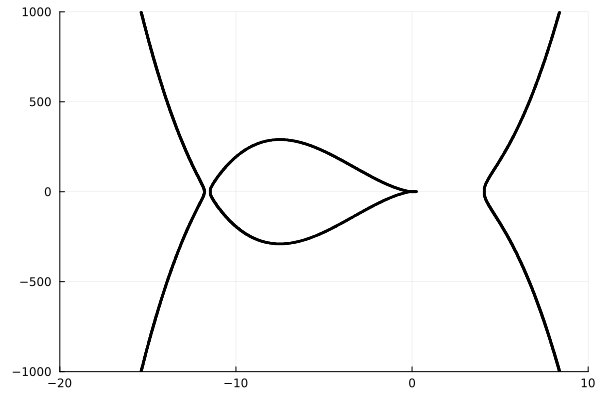

In [8]:
####Plot graph using Plots and Implicit Equations
f(x,y) = y^2 - ((x-real(p[1]))* (x-real(p[2]))*(x-real(p[3]))* (x-real(p[4]))*(x-real(p[5]))* (x-real(p[6])))

plot(f ⩵ 0, xlims = (-20,10), ylims=(-1000,1000), M=10, N=10, linewidth=2)  
#savefig("realcurve_nearerzero.png") 

## Computing the Riemann Matrix

In [9]:
function Riemann_Matrix(eta,theta, L,g)
    ##We are in the case of genus g
    #L is the length of words that we are generating in the free group
    (zs, ws, rs) = point_construct(eta, theta, g)
    println("Initialized circles")
    
    
    ##CONSTRUCT MATRICES FOR SCHOTTKY GROUP
    mat = matrix_construct(ws, zs, rs)
    println("Computed Matrices")
    
    R = zeros(ComplexF64,g, g) ##Initialize a gxg zero matrix
    
    list_of_words = all_words_bounded_length(L,g, mat)
    
    for i in 1:g
        for j in i:g #create the i-jth double coset mat[i]\ G/ [mat[j]]
            jCoset = []
            jCoset_mat = []
            for pts in list_of_words
                if pts[2] != j && pts[2] != -j && pts[3] != i && pts[3] != -i
                    push!(jCoset, pts)
                end
            end
            jCoset_mat = [pts[1] for pts in jCoset]
            popfirst!(jCoset_mat) #remove identity
            
        
            ##Aj and Bj are the fixed points
            jDisc = sqrt((mat[j][1,1] - mat[j][2,2])^2 + 4*mat[j][1,2]* mat[j][2,1]) #discriminant is sqrt((a-d)^2 + 4bc)
            Aj = ((mat[j][1,1] - mat[j][2,2])+ jDisc)/(2*mat[j][2,1])
            Bj = ((mat[j][1,1] - mat[j][2,2])- jDisc)/(2*mat[j][2,1])
            muj =  (mat[j][1,1] - mat[j][2,1]*Aj)/(mat[j][1,1] - mat[j][2,1]*Bj)
            #println(muj)
            iDisc = sqrt((mat[i][1,1] - mat[i][2,2])^2 + 4*mat[i][1,2]* mat[i][2,1]) #discriminant is sqrt((a-d)^2 + 4bc)
            Ai = ((mat[i][1,1] - mat[i][2,2])+ jDisc)/(2*mat[i][2,1])
            Bi = ((mat[i][1,1] - mat[i][2,2])- jDisc)/(2*mat[i][2,1])
            mui =  (mat[i][1,1] - mat[i][2,1]*Ai)/(mat[i][1,1] - mat[i][2,1]*Bi)
          
            if i != j
                samplevalue = 0
                for sig in jCoset_mat ##log {Aj, Bj, f Ai, f Bi}
                    samplevalue = samplevalue + log((Ai-mobius(sig,Aj)) * (Bi - mobius(sig,Bj)) / (Ai - mobius(sig,Bj))/ (Bi - mobius(sig,Aj))) 
                end
                R[i,j] = samplevalue
                R[j,i] = samplevalue
            else
                samplevalue = log(real(mui)) # add log(mui)
                for sig in jCoset_mat
                    samplevalue = samplevalue + log((Ai-mobius(sig,Aj)) * (Bi - mobius(sig,Bj)) / (Ai - mobius(sig,Bj))/ (Bi - mobius(sig,Aj)))
                end
                R[i,j] = samplevalue
            end
        end
    end
    return R    
end

Riemann_Matrix (generic function with 1 method)

In [10]:
####INPUT
𝜂 = pi/12;
𝜃 =pi/7;
L = 4;

mat = Riemann_Matrix(𝜂,𝜃 , L,6) ##Compute the genus g Riemann matrix

Initialized circles
Computed Matrices


6×6 Matrix{ComplexF64}:
  -3.94483+1.5077e-14im   0.0148278-2.80867e-14im  …  0.0148278-1.33155e-14im
 0.0148278-2.80867e-14im   -3.94483-2.27271e-14im      0.050031-2.27587e-14im
  0.050031+1.96342e-14im  0.0148278+3.92626e-14im     0.0326767-3.25849e-14im
 0.0326767-2.45312e-14im   0.050031-1.06096e-14im      0.050031+8.20058e-15im
  0.050031-2.44069e-14im  0.0326767+2.28302e-14im     0.0148278-7.85421e-15im
 0.0148278-1.33155e-14im   0.050031-2.27587e-14im  …   -3.94483-3.75163e-14im

In [11]:
imag(mat/ (2*pi*im)) ##Normalize to have positive definite imaginary part
eigvals(imag(mat/ (2*pi*im))) ## See the eigenvalues are indeed positive

6-element Vector{Float64}:
 0.6019929775465542
 0.6218339994008196
 0.6329607807358603
 0.6329607807358741
 0.6386422623267828
 0.638642262326798

## Approximating the Quartic in Genus 3

In [12]:
Pkg.add("Distributions") ##Add additional necessary packages
Pkg.add("DynamicPolynomials")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [13]:
using Distributions
using DynamicPolynomials

**Input** 
- Two numbers $0<\eta < \theta < \frac{\pi}{g}.$
- The number of points you want to sample on the curve $N>$ monomial basis length
- The length of words that we are generating in the free group $L$

**Output**
The approximate algebraic curve associated to the constructed curve, optimized by the method of least squares on the coefficients of basis of monomials over the real points.

In [14]:
𝜂 = pi/12;
𝜃 =pi/4;
L = 8; #Length of word trunction
N= 50; #Number of sample points


@polyvar z[1:3] #Define variables for the monomial basis
mons = monomials(z,4)
@polyvar c[1:length(mons)]

mons

15-element MonomialVector{DynamicPolynomials.Commutative{DynamicPolynomials.CreationOrder}, Graded{LexOrder}}:
 z₃⁴
 z₂z₃³
 z₂²z₃²
 z₂³z₃
 z₂⁴
 z₁z₃³
 z₁z₂z₃²
 z₁z₂²z₃
 z₁z₂³
 z₁²z₃²
 z₁²z₂z₃
 z₁²z₂²
 z₁³z₃
 z₁³z₂
 z₁⁴

In [15]:
function Genus3_Example(eta, theta, N, L) ## Constructs apporixmate polynomial and real points
    g=3 ##We are in the case of genus 3
    #L is the length of words that we are generating in the free group
    #N  is the number of points that we sample on the curve, N must be bigger than number of monomials in g variables
    (zs, ws, rs) = point_construct(eta, theta, g)
    println("Initialized circles")
   
    
    ##NOW SAMPLE N POINTS UNIFORMLY in the circle
    dunif = Uniform( 0, 2*pi) ##Initialize the uniform distribution
    samplepts = [exp(im*j) for j in rand(dunif, N)] #sample according to uniform distribution
    
    #Warning: The series do not converge at fixed points, to ensure these are not accidentally sampled
    #one could alternatively restrict to the subset of the circle contained in the fundamental domain
    println("Sampled N points on the curve")
    
    ##CONSTRUCT MATRICES FOR SCHOTTKY GROUP AND COMPUTE EIGENVALUES
    mat = matrix_construct(ws, zs, rs)
    println("Computed Matrices")
    
    
    ##Evaluate the points in P^g which are approximate images of the algebraic curve
    PointsinPg = ptheta(samplepts, mat, g, L)
    #return PointsinPg #end early and return image points in Pg
    
    nPoints = [] ##normalized points by looking in the chart where p[3] != 0
    for pt in PointsinPg
        push!(nPoints, (real(pt[1]/pt[3]), real(pt[2]/pt[3])))
    end
    println("Computed sample points in Pg")
    #return nPoints #end early and return only sampled points on the real curve
    
    ##Find approximate algebraic curve by solving least squares
    A = zeros(ComplexF64,Int(N), length(mons))
    for k in 1:N
       for j in 1:length(mons)
            A[k,j]= mons[j](Tuple(PointsinPg[k])) #A[k,j]= subs(mons[j], z=> Tuple(PointsinPg[k]))
        end
    end
    #Notice the vector of solutions A vec = 0 is given by (I-pseudoinverse(A)A)w for w any fixed vector
    vec = (Matrix(I,15,15) - pinv(A)*A)*[1 for pt in 1:15] 
    v = vec/norm(vec) #normalize to length 1
    
    polyf = 0 ##Construct the approximate polynomial
    for j in 1:length(mons)
        polyf = polyf + v[j]*mons[j]
    end
    return polyf, nPoints #return the polynomial and the real points
end

Genus3_Example (generic function with 1 method)

In [16]:
p1, realpoints = Genus3_Example(𝜂,𝜃 , N, L)  ##Note that if the sampling is bad, then we might end up with a bad approximation. Rerun, and see warning above to avoid this
p1
#realpoints

Initialized circles
Sampled N points on the curve
Computed Matrices
Computed sample points in Pg


(-0.006337603817408533 + 0.00010773445480193161im)z₃⁴ + (-0.03932096138847187 + 0.000658427947443144im)z₂z₃³ + (-0.29827921246807737 + 0.004973705363756725im)z₂²z₃² + (-0.03929766882620231 + 0.0006573671764774478im)z₂³z₃ + (-0.006339436936720869 + 0.00010520787358272959im)z₂⁴ + (-0.03931272581959844 + 0.000658080680721379im)z₁z₃³ + (0.49120951914162714 - 0.00823704915881956im)z₁z₂z₃² + (0.49108086124828987 - 0.008166286255333716im)z₁z₂²z₃ + (-0.03929804863076885 + 0.0006475246728534042im)z₁z₂³ + (-0.2982460314699331 + 0.004961117322096883im)z₁²z₃² + (0.4909347640331993 - 0.008083085785616577im)z₁²z₂z₃ + (-0.29824597260304253 + 0.004944619106816402im)z₁²z₂² + (-0.03929168130637379 + 0.000635227894926058im)z₁³z₃ + (-0.039282819822004246 + 0.0006616230956760202im)z₁³z₂ + (-0.006335782670993169 + 0.00010251950381448316im)z₁⁴

### Plotting approximate curve via a contour plot and the real points

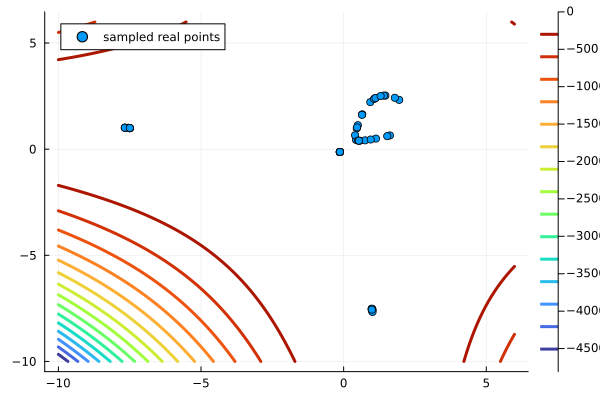

In [17]:
f(x, y) = real(p1(x,y,1)) #consider the real part of the polynomial

x = -10:.03:6 #x_0: r:x_1 means sample from x_0 to x_1 in intervals of .005
y = -10:.03:6
w = @. f(x',y)


myplot = scatter([pts[1] for pts in realpoints], [pts[2] for pts in realpoints], lab = "sampled real points")
myplot = contour!(x, y, w, color=:turbo, lw = 3)#, aspect_ratio=:equal)

myplot
#savefig(myplot, "etapi/12_thetapi/4_N50_L8.png")

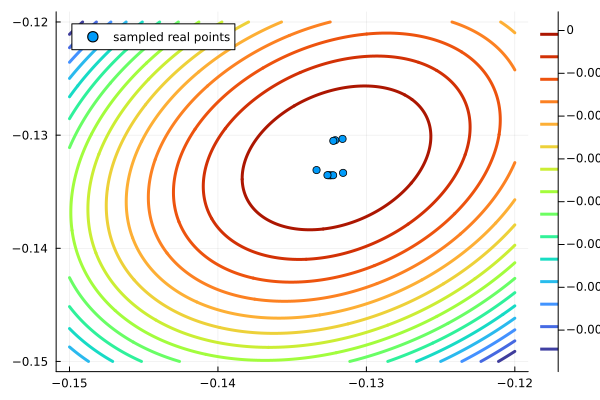

In [18]:
### Zooming in to a smaller range
x = -.15:.00001:-.12#range(-20, 10, length=5000)
y = -.15:.00001:-.12#range(-20, 10, length=5000)
w = @. f(x',y)

scatterx = []
scattery=[]
for pts in realpoints
    if pts[1] >= -.2 && pts[1] <=-.05
        if pts[2] >= -.2 && pts[2] <=-.05
            push!(scatterx, pts[1])
            push!(scattery, pts[2])
        end
    end
end
smallplot = scatter(scatterx, scattery, lab = "sampled real points")
smallplot = contour!(x, y, w, color=:turbo, lw = 3)#, aspect_ratio=:equal)

In [19]:
png(myplot, "etapi12_thetapi4_N50_L8.png")

"etapi12_thetapi4_N50_L8.png"

In [20]:
png(smallplot, "etapi12_thetapi4_N50_L8_zoom")

"etapi12_thetapi4_N50_L8_zoom.png"